In [1]:
import numpy as np
import math
import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp
from scipy.stats import norm
import statistics
plt.rcParams['text.usetex'] = False

# Getting r and rho from halo mass

In [2]:
# a fitting function to Diemer & Joyce 2019 z = 2 c(M):
#it’s a “piecewise-power-law fit to the concentration-mass relation at z = 2 from Diemer & Joyce (2019)”
def c_func(M_halo):
    c_values = np.array([5.606078101846313, 5.505601101255639, 5.296315905448495, 5.094986297483347, 4.901309860470804, 4.666519328282937, 4.500743526125894, 4.329656123893253, 4.154325163981534, 3.975808982640419, 3.834570325527022, 3.727126007769686, 3.6040211391832533, 3.512099050898484, 3.4225214744765236, 3.4402523213171285])
    scaled_M_values = np.array([1208795796.6963477, 1628413544.0132532, 2799360456.643171, 5080218046.9130125, 8973072494.285637, 18147780986.393196, 31197345819.126064, 52197182204.356415, 97327438615.81503, 191581222925.96384, 347677407476.5763, 566162599282.2716, 1114445470753.5625, 2193696137571.7903, 5976825664072.4, 14221361511653.348])
    scaled_M = M_halo/0.7
    return 10**np.interp(np.log10(scaled_M), np.log10(scaled_M_values), np.log10(c_values))


# NFW halo - eqs (3) and (4)

def r_0_func (M_halo):  ## in kpc
    rho_crit = 136 #Solar masses / kpc^3
    c = c_func(M_halo)
    # c = 5
    r_0 = 1/c * (3*M_halo/ (800 * math.pi * rho_crit))**(1/3)
    return (r_0)


def rho_0_func (M_halo):  # in 10^5 solar masses / kpc^3 ?????
    rho_crit = 0.00136 # 10^5 Solar masses / kpc^3
    c = c_func(M_halo)
    # c = 5
    rho_0 = 200/3 * c**3 * rho_crit / (np.log(1+c) - c/(1+c))
    return (rho_0)

# GC MASS DISTRIBUTION

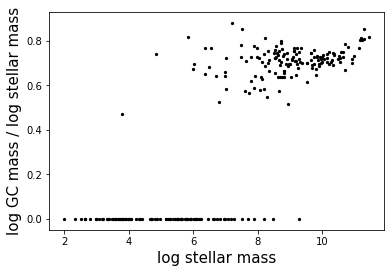

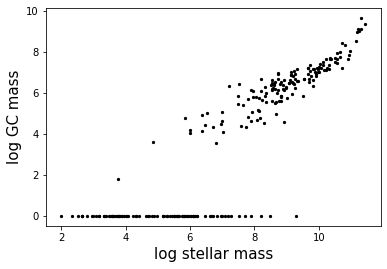

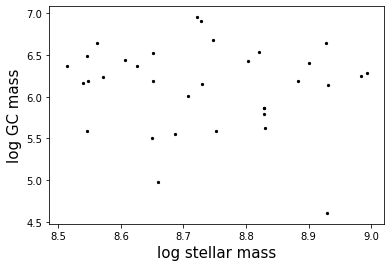

[6.23709418 0.43138218]


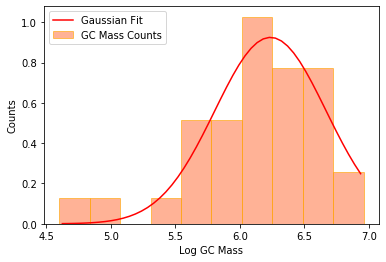

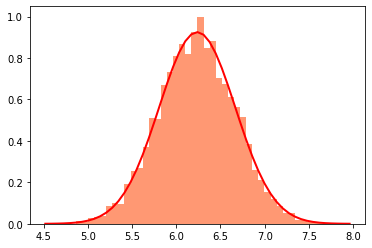

In [3]:
################################################
## GC MASS
################################################

## data that Shany sent on slack
dataGC = np.genfromtxt('best_sample.txt', skip_header=1, delimiter=',') ## from Shany's paper
M_GC = dataGC[:, 2] # log GC Mass (in solar masses)
M_S = dataGC[:, 4] #log Stellar Mass


###plot a scatter plot of said data
plt.scatter(M_S, M_GC/M_S, s=5, color = 'black')  ## Mgc or Mgc/Ms????
plt.xlabel('log stellar mass', fontsize=15)
plt.ylabel('log GC mass / log stellar mass', fontsize=15)
plt.show()

plt.scatter(M_S, M_GC, s=5, color = 'black')  ## Mgc or Mgc/Ms????
plt.xlabel('log stellar mass', fontsize=15)
plt.ylabel('log GC mass', fontsize=15)
plt.show()


################# VERTICAL STRIPE #################

### choose a range of stellar masses eg 8-8.25

## 7 - 8.25
## 8.25 - 9
## or nonlinear bins
lbound = 8.5     #lower bound of stellar mass of stripe
ubound = 9  #upper bound of stellar mass of stripe

## get stellar and GC masses within stripe
def GC_stripe_func (M_GC, M_S, lbound, ubound):
    M_GCstripe = [] 
    M_Sstripe = []
    n = len(M_GC)
    for i in range (n):
        if M_S[i] >= lbound and M_S[i] <= ubound and M_GC[i]!=0:
            M_GCstripe.append(M_GC[i])
            M_Sstripe.append(M_S[i])
    return [M_GCstripe, M_Sstripe]

M_GCstripe, M_Sstripe = GC_stripe_func (M_GC, M_S, lbound, ubound)
        
plt.scatter(M_Sstripe, M_GCstripe, s=5, color='black')
plt.xlabel('log stellar mass', fontsize=15)
plt.ylabel('log GC mass', fontsize=15)
plt.show()


################### DISTRIBUTION #################

plt.hist(M_GCstripe, bins=10, alpha=0.6, label='GC Mass Counts', color='coral', edgecolor='orange', density = True)

def Gaussian(x, mu, sigma):
    return 1/(sigma * np.sqrt(2 * np.pi)) * np.exp(-(x - mu)**2 / (2 * sigma**2))

def Gaussian_counts_bincenters(x, bins):
    counts, bin_edges = np.histogram(x, bins=bins, density = True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  ## get bin centers of histogram - will be used as x values for gaussian
    return [counts, bin_centers]

def Gaussian_params(x, bins):
    counts, bin_centers = Gaussian_counts_bincenters(x, bins)
    p0 = [np.mean(x), np.std(x)]  # Initial guess for the parameters
    params, cov = curve_fit(Gaussian, bin_centers, counts, p0=p0)
    return params  ## return mu and sigma of data to use for gaussian



params = Gaussian_params(M_GCstripe, bins=10) ## best fit params for if GC masses were split into 10 bins 
print(params)

curve_bin_centers = Gaussian_counts_bincenters(M_GCstripe, 50)[1] ## get bin centers for if historgram of GC masses was split into 50 bins - will be used as x values for gaussian curve

plt.plot(curve_bin_centers, Gaussian(curve_bin_centers, *params), 'r-', label='Gaussian Fit')
plt.xlabel('Log GC Mass')
plt.ylabel('Counts')
plt.legend()
plt.show()

#####################   SAMPLING MASSES FROM DISTRIBUTION ############################    
##sampling GC Mass for a given Stellar Mass

mu, sigma = Gaussian_params(M_GCstripe, bins=10)
def GC_random_sample (M_GCstripe, n):
    mu, sigma = Gaussian_params(M_GCstripe, bins=10)
    sample_masses = np.random.normal(mu, sigma, n)
    return sample_masses

count, bins, ignoored = plt.hist(GC_random_sample (M_GCstripe, 5000), 50, density=True, color = 'coral', alpha=0.8)
plt.plot(bins, Gaussian(bins, mu, sigma), linewidth=2, color='r')
plt.show()



# DARK MATTER HALO MASS DISTRIBUTION

[11.20296399]
0.43782999999999966


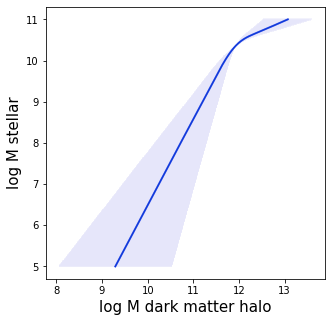

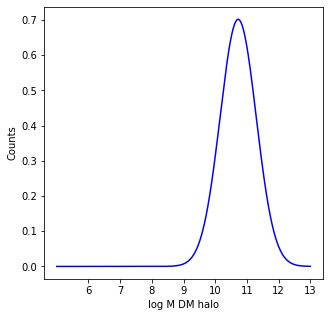

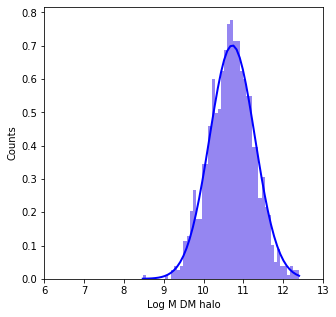

In [4]:
################################################
## DARK MATTER HALO MASS
################################################

from scipy.optimize import fsolve

#ELVES. IV. The Satellite Stellar-to-halo Mass Relation Beyond the Milky Way


#####################
##FIND M HALO VALUE FROM M STELLAR
########################
# Values and equation from Shany's paper - section 4.2, eq 1

## Equation from Shany's paper
def logMstellar_eq(logMhalo):
    M1 = 11.889
    alpha = 2.1
    beta = 0.464
    epsilon = -1.432
    loggamma = -0.812
    gamma = 10**loggamma
    delta = 0.319
    x = np.log10(10**logMhalo/10**M1)
    logMstellar = epsilon + M1 - np.log10(10**(-alpha*x) + 10**(-beta*x)) + gamma*np.exp(-0.5*(x/delta)**2)
    return logMstellar

## Solve for Mhalo value for given Mstellar value (solve y(x) eq for x value)
def logMhalo_eq (logMstellar):
    func = lambda x: logMstellar_eq(x) - logMstellar  ## def f(x) = 0
    logMhalo_guess = 12
    logMhalo = fsolve(func, logMhalo_guess) ##returns roots of func
    return(logMhalo)

logMstellar = 9
logMhalo = logMhalo_eq(logMstellar)
print(logMhalo)


#################################### 
################## STNDARD DEVIATION ###################

def std_eq (logMhalo):
    sigma0 = 0.02
    nu = -0.47
    M1 = 11.889
    logsigma = sigma0 + nu * (logMhalo - M1)
    return (logsigma)

print(std_eq(11))



################################################
########### DISTRIBUTION #########################

Mstellar = np.logspace(5, 11, 500, base=10)
logMstellar = np.log10(Mstellar)
mean_Mhalos = [] ## M halos for these stellar values
logsigmas = []  ## standard deviations for these M halo values

for i in range (len(logMstellar)):
    logMhalo = logMhalo_eq(logMstellar[i])
    mean_Mhalos.extend (logMhalo) ## gives value of mean halos (not log)
    logsigmas.extend(abs(std_eq(logMhalo)))
    
plt.figure(figsize=(5,5))
plt.plot(mean_Mhalos, logMstellar)
plt.errorbar(mean_Mhalos, logMstellar, xerr = logsigmas, color = 'blue', linewidth = 2, ecolor='lavender', alpha = 0.5)
plt.xlabel('log M dark matter halo', size = 15)
plt.ylabel('log M stellar', size = 15)
plt.xticks(np.linspace(8, 13, 6))
plt.show()



#############################################################
##########PLOT GAUSSIAN FOR GIVEN M STELLAR #######################

plt.figure(figsize=(5,5))
logMstellar = 8
mu = logMhalo_eq(logMstellar)  ##log
sigma = std_eq(mu)  ##log

Mhalos = np.linspace(5, 13, 1000) # Generate x values
gaus = Gaussian(Mhalos, mu, sigma)  # Generate y values

# Plot the Gaussian function
plt.plot(Mhalos, gaus, 'b')
plt.xlabel('log M DM halo')
plt.ylabel('Counts')
plt.xticks(np.linspace(6, 13, 8))
plt.show()



############################################################################
############## SAMPLE MASSES FROM DISTRIBUTION ##############################

def DM_random_sample (logMstellar, n):
    mu = logMhalo_eq(logMstellar)  ##log
    sigma = std_eq(mu)  ##log
    sample_masses = np.random.normal(mu, sigma, n)
    return (sample_masses)

plt.figure(figsize=(5,5))
count, bins, ignoored = plt.hist(DM_random_sample (logMstellar, 1000), 50, density=True, color = 'mediumslateblue', alpha=0.8)
plt.plot(bins, Gaussian(bins, mu, sigma), linewidth=2, color='b')
plt.xticks(np.linspace(6, 13, 8))
plt.xlabel('Log M DM halo')
plt.ylabel('Counts')
plt.show()


# Re DISTRIBUTION

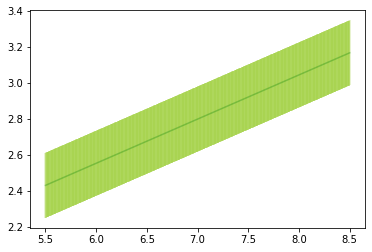

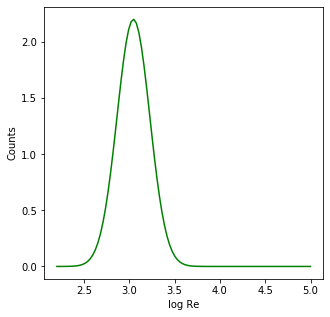

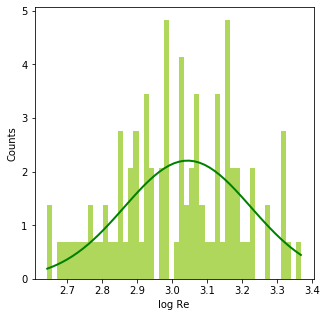

In [5]:
################################################
## Re
################################################

# Eq 5 section 3.5 from paper Shany sent
# Structures of Dwarf Satellites of Milky Way-like Galaxies: Morphology, Scaling Relations, and Intrinsic Shapes
# dwarves in mass range 5.5 < M < 8.5

def logRe_eq (logMstellar):
    a = 1.077
    b = 0.246
    logRe = a + b*logMstellar
    return logRe

sigma = 0.181
logMstellar = np.linspace(5.5, 8.5, 1000)
Re = logRe_eq(logMstellar)

plt.errorbar(logMstellar, Re, yerr = sigma, color = 'green', ecolor = 'yellowgreen', alpha = 0.3)
plt.show



logMstellar = 8
########## Gaussian ##########

plt.figure(figsize=(5,5))
mu = logRe_eq(logMstellar)  
sigma = 0.181 

logRe = np.linspace(2.2, 5, 100) # Generate x values
gaus = Gaussian(logRe, mu, sigma)  # Generate y values

# Plot the Gaussian function
plt.plot(logRe, gaus, 'g')
plt.xlabel('log Re')
plt.ylabel('Counts')
#plt.xticks(np.linspace(6, 13, 8))
plt.show()



######## SAMPLE FROM DISTRIBUTION
#####################   SAMPLING MASSES FROM DISTRIBUTION ############################    
##sampling GC Mass for a given Stellar Mass
def Re_random_sample (logMstellar, n):
    mu = logRe_eq(logMstellar)
    sigma = 0.181  
    sample_Re = np.random.normal(mu, sigma, n)
    return sample_Re

plt.figure(figsize=(5,5))
count, bins, ignoored = plt.hist(Re_random_sample (logMstellar, 100), 50, density=True, color = 'yellowgreen', alpha=0.8)
plt.plot(bins, Gaussian(bins, mu, sigma), linewidth=2, color='g')
plt.xlabel('log Re')
plt.ylabel('Counts')
plt.show()

# GRID PLOTS

<function matplotlib.pyplot.show(*args, **kw)>

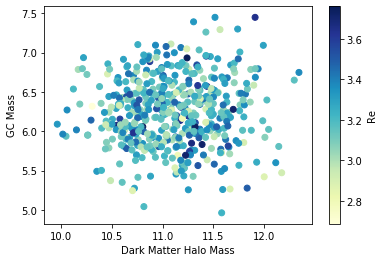

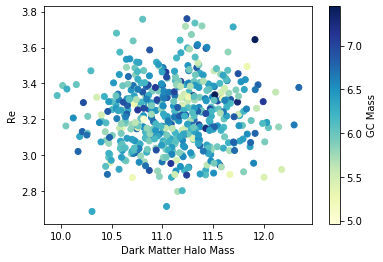

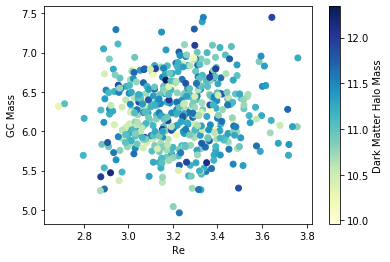

In [6]:
######################################################################
### GRID PLOTS 
######################################################################

logMstellar = 8.75
n = 500

DM_sample = DM_random_sample(logMstellar, n)
Re_sample = Re_random_sample(logMstellar, n)

M_GCstripe, M_Sstripe = GC_stripe_func (M_GC, M_S, lbound, ubound)
GC_sample = GC_random_sample(M_GCstripe, n)

####M DM HALO VS M GC #########
plt.figure()
plt.scatter(DM_sample, GC_sample, c = Re_sample, cmap = 'YlGnBu')
colorbar = plt.colorbar()
colorbar.set_label('Re')
plt.xlabel('Dark Matter Halo Mass')
plt.ylabel('GC Mass')
plt.show

####### M DM HALO VS Re #########
plt.figure()
plt.scatter(DM_sample, Re_sample, c = GC_sample, cmap = 'YlGnBu')
colorbar = plt.colorbar()
colorbar.set_label('GC Mass')
plt.xlabel('Dark Matter Halo Mass')
plt.ylabel('Re')
plt.show


####### Re VS M GC  #########
plt.figure()
plt.scatter(Re_sample, GC_sample, c = DM_sample, cmap = 'YlGnBu')
colorbar = plt.colorbar()
colorbar.set_label('Dark Matter Halo Mass')
plt.xlabel('Re')
plt.ylabel('GC Mass')
plt.show

In [ ]:
def behroozi2019_fit(mhalo, alpha=1.959, z=0):

    eps = -1.432
    logM1 = 11.889
    m1 = 10**logM1
    beta = 0.464
    delta = 0.319
    log_gamma = -0.812
    
    x = np.log10(mhalo/m1)
    lg_mstar = logM1 + eps - np.log10(10**(-alpha*x) + 10**(-beta*x)) + 10**log_gamma*np.exp(-0.5*(x/delta)**2)
    
    return 10**lg_mstar

alpha = 2.10 # slope

mhalo = 10**11.20296399
log_mstar_median = np.log10(behroozi2019_fit(mhalo, alpha=alpha))

print(log_mstar_median)

In [ ]:
## include scatter for random draws
##main plot once we do random sampling  Mhalo Re plane - get a weird blob - make a grid
## scatter plot - 100 draws from distributio - do 3 panles
## Mh vs Re, Mh vs Mgc, Re vs Mgc
##hve points be colored by the value of the third coordinate

In [ ]:
# hist, bin_edges = np.histogram(M_GCstripe, bins=50, density=True)
# bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
# p0 = [np.mean(M_GCstripe), np.std(M_GCstripe)]  # Initial guess for the parameters
# params, cov = curve_fit(gaussian, bins[:-1], count, p0=p0)

# plt.hist(M_GCstripe, bins=10, density=True, alpha=0.6, label='GC Mass Counts', color='coral')
# plt.plot(bin_centers, gaussian(bin_centers, *params), 'r-', label='Gaussian Fit')
# plt.xlabel('Log GC Mass')
# plt.ylabel('Counts')
# plt.legend()
# plt.show()